First, please upload train.xlsx to /content

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_excel('/content/train.xlsx')

train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=2, stratify=df[['label','type']])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=2, stratify=valid_test[['label','type']])
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [2]:
!pip install transformers[ja] -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import time
from tqdm.notebook import tqdm

import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertJapaneseTokenizer, BertModel, AutoTokenizer, AutoModel
from torch import optim
from torch import cuda
import torch.nn.functional as F
from matplotlib import pyplot as plt
import cloudpickle

SEED_VALUE = 123
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed(SEED_VALUE)

In [4]:
class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.y)

  def __getitem__(self, index):
    text = self.X[index]
    inputs = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      padding='max_length',
      truncation=True,
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']

    return {
      'ids': torch.LongTensor(ids),
      'mask': torch.LongTensor(mask),
      'labels': torch.Tensor(self.y[index]),
      'text': text,
    }

131


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


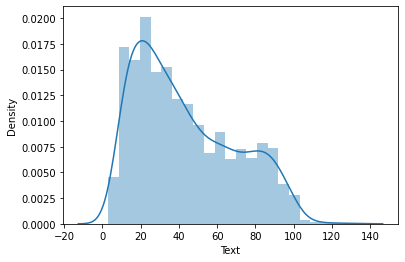

In [5]:
tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

import seaborn as sns
title_length = df['Text'].map(tokenizer.encode).map(len)
print(max(title_length))

sns.distplot(title_length)

In [6]:
y_train = pd.get_dummies(train, columns=['label'])[['label_0', 'label_1', 'label_2']].values
y_valid = pd.get_dummies(valid, columns=['label'])[['label_0', 'label_1', 'label_2']].values
y_test = pd.get_dummies(test, columns=['label'])[['label_0', 'label_1', 'label_2']].values

max_len = 131

dataset_train = CreateDataset(train['Text'], y_train, tokenizer, max_len)
dataset_valid = CreateDataset(valid['Text'], y_valid, tokenizer, max_len)
dataset_test = CreateDataset(test['Text'], y_test, tokenizer, max_len)

In [7]:
class BERTClass(torch.nn.Module):
  def __init__(self, drop_rate, output_size):
    super().__init__()
    self.bert = BertModel.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
    self.drop = torch.nn.Dropout(drop_rate)
    self.fc = torch.nn.Linear(768, output_size)

  def forward(self, ids, mask):
    _, out = self.bert(ids, attention_mask=mask, return_dict=False)
    out = self.fc(self.drop(out))
    return out

  # def _get_cls_vec(self, vec):
  #       return vec[:,0,:].view(-1, 768)

  # def forward(self, input_ids, mask):

  #       output = self.bert(input_ids, attention_mask=mask)
  #       # attentions = output['attentions']
  #       hidden_states = output['hidden_states']

  #       vec1 = self._get_cls_vec(hidden_states[-1])
  #       vec2 = self._get_cls_vec(hidden_states[-2])
  #       vec3 = self._get_cls_vec(hidden_states[-3])
  #       vec4 = self._get_cls_vec(hidden_states[-4])

  #       vec = torch.cat([vec1, vec2, vec3, vec4], dim=1)

  #       out1 = self.drop(vec)
  #       #out2 = self.linear(out1)
  #       #out2 = self.linear(vec)

  #       # __, bilstm_hc = self.bilstm(out1)
  #       # bilstm_out = torch.cat([bilstm_hc[0][0], bilstm_hc[0][1]],dim=1)
  #       out2 = self.fc(out1)

        # return F.log_softmax(out2, dim=1)

In [8]:
class EarlyStopping:

    def __init__(self, patience=5, verbose=False, path='checkpoint_model.pth'):

        self.patience = patience  
        self.verbose = verbose     
        self.counter = 0        
        self.best_score = None     
        self.early_stop = False    
        self.val_loss_min = np.Inf   
        self.path = path            

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:  
            self.best_score = score 
            self.checkpoint(val_loss, model) 
        elif score < self.best_score: 
            self.counter += 1  
            if self.verbose:  
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}') 
            if self.counter >= self.patience:  
                self.early_stop = True
        else: 
            self.best_score = score  
            self.checkpoint(val_loss, model) 
            self.counter = 0 

    def checkpoint(self, val_loss, model):
        if self.verbose: 
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        with open('/content/best_model.pkl','wb') as f:
          cloudpickle.dump(model,f)
        self.val_loss_min = val_loss

In [9]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:

      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      outputs = model(ids,mask)
      loss += criterion(outputs, labels)

      pred = torch.argmax(outputs, dim=-1).cpu().numpy()
      labels = torch.argmax(labels, dim=-1).cpu().numpy()
      total += len(labels)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  model.to(device)

  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  log_train = []
  log_valid = []
  
  earlystopping = EarlyStopping(patience=2, verbose=True)

  for epoch in tqdm(range(num_epochs)):
    s_time = time.time()

    model.train()
    for data in tqdm(dataloader_train):
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      optimizer.zero_grad()

      outputs = model(ids,mask)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    e_time = time.time()
 
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')
    earlystopping(loss_valid, model)
    if earlystopping.early_stop:
        print("Early Stopping!")
        with open('/content/best_model.pkl', mode='rb') as f:
          model = cloudpickle.load(f)
          model.to(device)
        break
    
  return {'train': log_train, 'valid': log_valid}

In [10]:
import torch.optim as optim
learning_rate = 1e-5
DROP_RATE = 0.4
OUTPUT_SIZE = 3
BATCH_SIZE = 32
NUM_EPOCHS = 10
model = BERTClass(DROP_RATE, OUTPUT_SIZE)

# optimizer setting
# param_optimizer = list(model.named_parameters())
# no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']
# optimizer_grouped_parameters = []
# max_lrs = []
# for param in param_optimizer:
#   if any(n in param[0] for n in no_decay):
#     weight_decay = 0.0
#   else:
#     weight_decay = 0.1
#   if param[0].find("bert.encoder.layer") != -1:
#     n_diff_last = 11 - int(param[0].split(".")[3])
#     lr = learning_rate*0.9**n_diff_last
#   elif "embeddings" in param[0]:
#     lr = learning_rate*0.9**11
#   else:
#     lr = learning_rate
#   max_lrs.append(lr)
#   d = {"params": param[1], "weight_decay": weight_decay}
#   optimizer_grouped_parameters.append(d)

# optimizer = optim.AdamW(optimizer_grouped_parameters, lr=learning_rate)
optimizer = optim.AdamW(params=model.parameters(), lr=learning_rate)

torch.cuda.empty_cache()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
criterion = torch.nn.BCEWithLogitsLoss()

device = 'cuda' if cuda.is_available() else 'cpu'

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 1, loss_train: 0.4800, accuracy_train: 0.6603, loss_valid: 0.5021, accuracy_valid: 0.6381, 83.3465sec
Validation loss decreased (inf --> 0.502072).  Saving model ...


  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 2, loss_train: 0.3323, accuracy_train: 0.8083, loss_valid: 0.3800, accuracy_valid: 0.7365, 81.3680sec
Validation loss decreased (0.502072 --> 0.380003).  Saving model ...


  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 3, loss_train: 0.2225, accuracy_train: 0.8885, loss_valid: 0.3440, accuracy_valid: 0.7524, 81.7813sec
Validation loss decreased (0.380003 --> 0.343979).  Saving model ...


  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 4, loss_train: 0.1404, accuracy_train: 0.9401, loss_valid: 0.3397, accuracy_valid: 0.7460, 81.0192sec
Validation loss decreased (0.343979 --> 0.339657).  Saving model ...


  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 5, loss_train: 0.0900, accuracy_train: 0.9663, loss_valid: 0.3698, accuracy_valid: 0.7619, 81.0927sec
EarlyStopping counter: 1 out of 2


  0%|          | 0/79 [00:00<?, ?it/s]

epoch: 6, loss_train: 0.0658, accuracy_train: 0.9762, loss_valid: 0.4091, accuracy_valid: 0.7683, 81.3320sec
EarlyStopping counter: 2 out of 2
Early Stopping!


In [12]:
with open('/content/best_model.pkl', mode='rb') as f:
  model = cloudpickle.load(f)
  device = 'cuda' if cuda.is_available() else 'cpu'
  model.to(device)

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def calculate_accuracy(model, dataset, device):
  loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

  model.eval()
  total = 0
  correct = 0
  pred_list = []
  with torch.no_grad():
    for data in loader:
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      outputs = model.forward(ids, mask)
      pred = torch.argmax(outputs, dim=-1).cpu().numpy()
      prob = torch.argmax(outputs, dim=-1).sigmoid().cpu().numpy()
      labels = torch.argmax(labels, dim=-1).cpu().numpy()
      total += len(labels)
      correct += (pred == labels).sum().item()

    y_pred = pred
    print(confusion_matrix(labels, y_pred))
    print(classification_report(labels, y_pred, target_names=['Primary', 'Secondary', 'Sesquiary'],digits=3))

  return pred, prob

pred, prob = calculate_accuracy(model, dataset_test, device)
#pred, prob = calculate_accuracy(model, dataset_valid, device)
torch.cuda.empty_cache()

[[81  7 17]
 [ 8 89  8]
 [15  8 82]]
              precision    recall  f1-score   support

     Primary      0.779     0.771     0.775       105
   Secondary      0.856     0.848     0.852       105
   Sesquiary      0.766     0.781     0.774       105

    accuracy                          0.800       315
   macro avg      0.800     0.800     0.800       315
weighted avg      0.800     0.800     0.800       315



In [ ]:
result = pd.DataFrame()
result['Text'] = test['Text']
result['label'] = test['label']
result['pred'] = pred
result['prob'] = prob
result.to_csv('/content/result.csv', index=False)
result.head()